In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import cv2
import os
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Activation,Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from keras.models import load_model

from keras.layers import Dropout,BatchNormalization,Flatten,Input

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [22]:
# check if any GPU available
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
# return the current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: d:\Học tập 3\Digital_Processing\Project2\utkcropped


In [6]:
age = []
gender = [] 
images_path_names = []
 
# add data into 3 lists above to prepare data for training
# take label from file name with format age_gender_datatime
for filename in os.listdir(cwd):
    image_path = os.path.join(cwd, filename)
    try:
        elements=  filename.split('_')
        age.append(int(elements[0]))
        gender.append(int(elements[1]))
        images_path_names.append(image_path)
    except:
        pass

In [7]:
# create dataframe
df = pd.DataFrame({"dir":images_path_names,"age":age,"gender":gender})

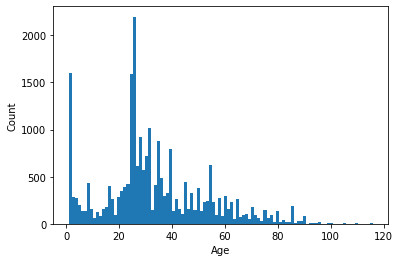

In [21]:
# use histogram graph to visualize distribution of age in dataset
plt.hist(df["age"],bins = 100)
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In [2]:
# divide dataset into 9 classes of age
age_classes = ['0-8', '9-22', '23-25', '26-27', '28-31', '32-36', '37-47','48-58','60+']

In [8]:
# make label for each class
def label_age(age):
    if 0 <= age <= 8:
        return 0
    elif 9 <= age <= 22:
        return 1
    elif 23 <= age <= 25:
        return 2
    elif 26 <= age <= 27:
        return 3
    elif 28 <= age <= 31:
        return 4
    elif 32 <= age <= 36:
        return 5
    elif 37 <= age <= 47:
        return 6
    elif 48 <= age <= 58:
        return 7
    else:
        return 8

In [9]:
# convert age into label
df['age'] = df['age'].map(label_age)
df.head()

,dir,age,gender
0,d:\Học tập 3\Digital_Processing\Project2\utkcr...,8,0
1,d:\Học tập 3\Digital_Processing\Project2\utkcr...,8,0
2,d:\Học tập 3\Digital_Processing\Project2\utkcr...,8,1
3,d:\Học tập 3\Digital_Processing\Project2\utkcr...,8,1
4,d:\Học tập 3\Digital_Processing\Project2\utkcr...,8,1


In [31]:
print(df.value_counts(df.age))

age
0    2896
6    2828
3    2812
8    2773
1    2722
5    2579
4    2562
7    2518
2    2019
dtype: int64


In [10]:
# take 2000 samples in each class to train
classs = list(range(9))
data = pd.DataFrame({"dir":[],"age":[]})
for i in classs:
    grouped = df.groupby(df['age'])
    slices = grouped.get_group(i)
    threshold = 2000
    slices = slices.iloc[:threshold]
    data = pd.concat([data, slices], ignore_index=True)

# suffle data
data = data.sample(frac = 1)

# check result
print(data.head())
print()
print(data.value_counts(data.age))

                                                     dir  age  gender
16335  d:\Học tập 3\Digital_Processing\Project2\utkcr...  8.0     1.0
3328   d:\Học tập 3\Digital_Processing\Project2\utkcr...  1.0     1.0
15559  d:\Học tập 3\Digital_Processing\Project2\utkcr...  7.0     0.0
10124  d:\Học tập 3\Digital_Processing\Project2\utkcr...  5.0     0.0
14311  d:\Học tập 3\Digital_Processing\Project2\utkcr...  7.0     0.0

age
0.0    2000
1.0    2000
2.0    2000
3.0    2000
4.0    2000
5.0    2000
6.0    2000
7.0    2000
8.0    2000
dtype: int64


In [11]:
# convert into list
train_dir_list = list(data['dir'])
train_age_list = list(data['age'].astype("int32"))

In [13]:
# convert into tensor format
train_dir_tensor = tf.constant(train_dir_list)
train_age_tensor = tf.constant(train_age_list)

In [14]:
# preprocess image and make vector label for each image
num_classes = 9

def parse_function_age(filename, label):
    
    image_string = tf.io.read_file(filename)
    # channels=1 to convert to grayscale, channels=3 to convert to RGB
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)
    # crop image into 128x128  
    cropped_img = tf.image.central_crop(image_decoded, central_fraction=0.64)
    # create one hot vector label of image
    label = tf.one_hot(label, num_classes)

    return cropped_img, label

In [15]:
# create data for training
train_data_age = tf.data.Dataset.from_tensor_slices((train_dir_tensor, train_age_tensor))
train_data_age = train_data_age.map(parse_function_age)
train_data_age = train_data_age.batch(10)

In [27]:
cnn = Sequential()

# input layer with 64 filters, followed by an MaxPooling2D layer
# 3rd dim = 1 for grayscale images
cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(128,128, 1)))    
cnn.add(BatchNormalization(axis=3))
cnn.add(MaxPooling2D(pool_size=(2,2)))

# three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))

# A GlobalMaxPooling2D layer before going into Dense layers below.
# GlobalMaxPooling2D layer gives number of outputs equal to number of filters in last Conv2D layer above
cnn.add(GlobalMaxPooling2D())

# two dense with 512 node and 1 dense 9 node for fully connected layer
cnn.add(Dense(512, activation='relu'))
cnn.add(Dense(512,activation="relu"))

cnn.add(Dropout(0.4))

# output layer with 9 nodes (equal to the number of classes).
cnn.add(Dense(9, activation='softmax'))

In [28]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                        

In [16]:
cnn.compile(loss='binary_crossentropy', metrics=["accuracy"], optimizer="adam")

In [12]:
 # create tensorboard
tensorboard = TensorBoard(log_dir=f"d:/Học tập 3/Digital_Processing/Project2/utkcropped/output/cnn_logs")
# create checkpoint to save best validation accuracy
checkpoint = ModelCheckpoint(filepath=f"d:/Học tập 3/Digital_Processing/Project2/utkcropped/output/cnn_logs/age_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

In [16]:
# first, train data with 60 epochs
history = cnn.fit(train_data_age,validation_data=train_data_age,batch_size=10,epochs=60,callbacks=[tensorboard, checkpoint],shuffle=False)

Epoch 1/60
1798/1800 [============================>.] - ETA: 0s - loss: 0.3241 - accuracy: 0.2270
Epoch 1: val_accuracy improved from -inf to 0.24167, saving model to d:/Học tập 3/Digital_Processing/Project2/utkcropped/output/cnn_logs\age_model_checkpoint.h5
1800/1800 [==============================] - 77s 37ms/step - loss: 0.3240 - accuracy: 0.2271 - val_loss: 0.3216 - val_accuracy: 0.2417
Epoch 2/60
1800/1800 [==============================] - ETA: 0s - loss: 0.2877 - accuracy: 0.3216
Epoch 2: val_accuracy improved from 0.24167 to 0.33717, saving model to d:/Học tập 3/Digital_Processing/Project2/utkcropped/output/cnn_logs\age_model_checkpoint.h5
1800/1800 [==============================] - 64s 36ms/step - loss: 0.2877 - accuracy: 0.3216 - val_loss: 0.2787 - val_accuracy: 0.3372
Epoch 3/60
1800/1800 [==============================] - ETA: 0s - loss: 0.2725 - accuracy: 0.3541
Epoch 3: val_accuracy improved from 0.33717 to 0.38306, saving model to d:/Học tập 3/Digital_Processing/Project

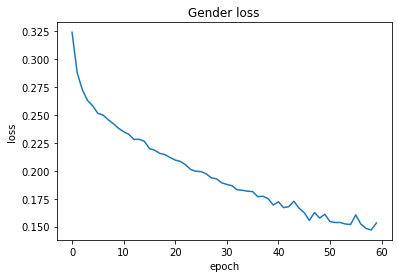

In [18]:
# visualize loss during 60 epochs
plt.plot(history.history['loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [17]:
# save parameters after training
cnn.save("d:/Học tập 3/Digital_Processing/Project2/utkcropped/output/cnn_logs/model_60_epochs_age_balan.h5", save_format='h5')

In [16]:
# defining a function to plot the confusion matrix in a grid for easier visualization
"""
this function prints and plots the confusion matrix
normalization can be applied by setting normalize=True
"""
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # exporting plot image in PNG format.
    plt.savefig(f'd:/Học tập 3/Digital_Processing/Project2/utkcropped/output/cnn_logs/{export_as}.png', bbox_inches='tight')

In [17]:
# calulate confusion matrix with train_data_age
maxt = confusion_matrix(data.age,cnn.predict(train_data_age).argmax(axis=-1))
maxt

1800/1800 [==============================] - 152s 78ms/step


array([[1916,   49,    4,    8,   11,    4,    3,    1,    4],
       [   7, 1779,   20,   51,   76,   48,   15,    2,    2],
       [   0,  401,  714,  241,  393,  223,   20,    5,    3],
       [   1,  149,   66, 1158,  248,  341,   31,    2,    4],
       [   0,  252,   61,  222,  700,  685,   65,   14,    1],
       [   0,  142,   28,  242,  352, 1036,  148,   45,    7],
       [   0,  106,    7,   97,  133,  786,  672,  173,   26],
       [   0,   39,    5,   13,   34,  286,  246, 1272,  105],
       [   0,   34,    1,    5,    2,   84,   56,  287, 1531]],
      dtype=int64)

Normalized confusion matrix


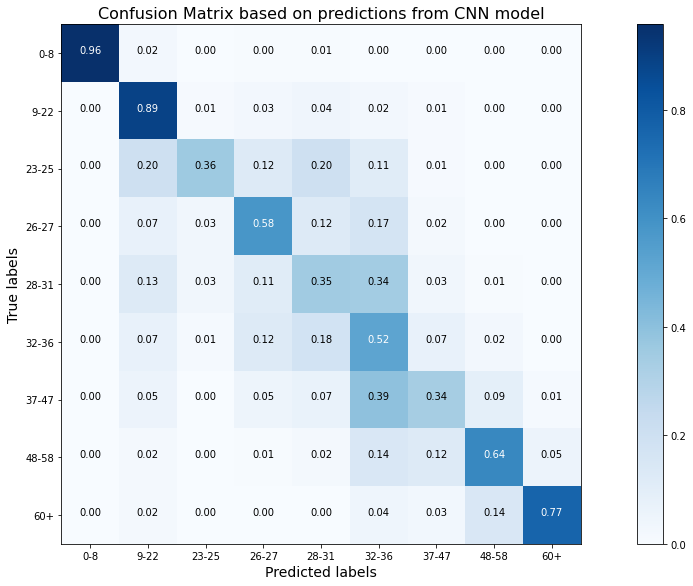

In [18]:
# visualize confusion matrix
plt.figure(figsize=(16,8))
plot_confusion_matrix(maxt, age_classes, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="confusion_matrix_after_60_epochs"
                     )

plt.show()

### Continue train 40 epochs

In [ ]:
# load pretrained model
model = load_model("d:/Học tập 3/Digital_Processing/Project2/utkcropped/output/cnn_logs/model_60_epochs_age_balan.h5")

In [23]:
# continue training 40 epochs
his = model.fit(train_data_age,validation_data=train_data_age,batch_size=10,epochs=40,callbacks=[tensorboard, checkpoint],shuffle=False)

Epoch 1/40
1800/1800 [==============================] - ETA: 0s - loss: 0.1787 - accuracy: 0.6310
Epoch 1: val_accuracy improved from -inf to 0.53228, saving model to d:/Học tập 3/Digital_Processing/Project2/utkcropped/output/cnn_logs\age_model_checkpoint.h5
1800/1800 [==============================] - 68s 37ms/step - loss: 0.1787 - accuracy: 0.6310 - val_loss: 0.2490 - val_accuracy: 0.5323
Epoch 2/40
1800/1800 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.6420
Epoch 2: val_accuracy improved from 0.53228 to 0.65889, saving model to d:/Học tập 3/Digital_Processing/Project2/utkcropped/output/cnn_logs\age_model_checkpoint.h5
1800/1800 [==============================] - 66s 37ms/step - loss: 0.1696 - accuracy: 0.6420 - val_loss: 0.1626 - val_accuracy: 0.6589
Epoch 3/40
1799/1800 [============================>.] - ETA: 0s - loss: 0.1624 - accuracy: 0.6598
Epoch 3: val_accuracy did not improve from 0.65889
1800/1800 [==============================] - 71s 39ms/step -

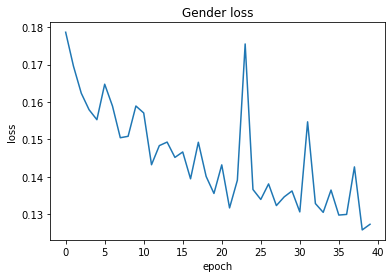

In [28]:
# visualize loss during next 40 epochs
plt.plot(his.history['loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [25]:
# save parameters after continue training 40 epochs
model.save("d:/Học tập 3/Digital_Processing/Project2/utkcropped/output/cnn_logs/model_100_epochs_age_balan.h5", save_format='h5')

In [20]:
# calcualate confusion matrix after 100 epochs
maxt1 = confusion_matrix(data.age,model.predict(train_data_age).argmax(axis=-1))
maxt1

1800/1800 [==============================] - 138s 77ms/step


array([[1987,    3,    0,    4,    0,    2,    2,    0,    2],
       [  40, 1719,   82,   24,   63,   52,   15,    2,    3],
       [  14,  143, 1383,   83,  255,  100,   17,    4,    1],
       [  16,   82,  165, 1136,  266,  255,   69,    9,    2],
       [  15,   97,  179,  117,  769,  673,  125,   23,    2],
       [   5,   66,   66,  153,  266,  981,  385,   68,   10],
       [   3,   36,   13,   62,   72,  386, 1230,  178,   20],
       [   3,    9,   10,    9,   15,   71,  247, 1558,   78],
       [  15,   15,    3,    8,    1,   23,   78,  252, 1605]],
      dtype=int64)

Normalized confusion matrix


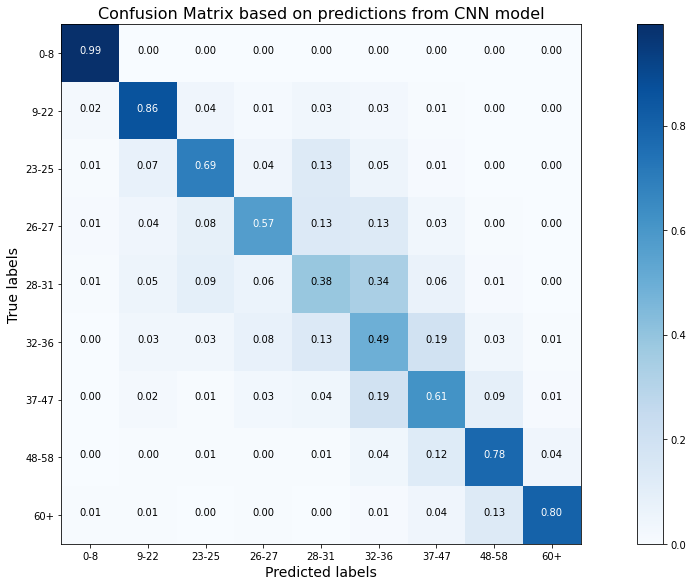

In [21]:
plt.figure(figsize=(16,8))
plot_confusion_matrix(maxt1, age_classes, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="confusion_matrix_after_100_epochs"
                     )

plt.show()

### Continue training 40 epochs

In [ ]:
# load pretrained 100 epochs model 
model = load_model("d:/Học tập 3/Digital_Processing/Project2/utkcropped/output/cnn_logs/model_100_epochs_age_balan.h5")

In [15]:
# continue training 40 epochs
his = model.fit(train_data_age,validation_data=train_data_age,batch_size=10,epochs=40,callbacks=[tensorboard, checkpoint],shuffle=False)

Epoch 1/40
1798/1800 [============================>.] - ETA: 0s - loss: 0.1634 - accuracy: 0.6750
Epoch 1: val_accuracy improved from -inf to 0.74256, saving model to d:/Học tập 3/Digital_Processing/Project2/utkcropped/output/cnn_logs\age_model_checkpoint.h5
1800/1800 [==============================] - 70s 36ms/step - loss: 0.1633 - accuracy: 0.6753 - val_loss: 0.1995 - val_accuracy: 0.7426
Epoch 2/40
1800/1800 [==============================] - ETA: 0s - loss: 0.1665 - accuracy: 0.6642
Epoch 2: val_accuracy did not improve from 0.74256
1800/1800 [==============================] - 64s 36ms/step - loss: 0.1665 - accuracy: 0.6642 - val_loss: 0.1675 - val_accuracy: 0.6716
Epoch 3/40
1799/1800 [============================>.] - ETA: 0s - loss: 0.1462 - accuracy: 0.7065
Epoch 3: val_accuracy did not improve from 0.74256
1800/1800 [==============================] - 67s 37ms/step - loss: 0.1462 - accuracy: 0.7065 - val_loss: 0.2306 - val_accuracy: 0.7332
Epoch 4/40
1799/1800 [================

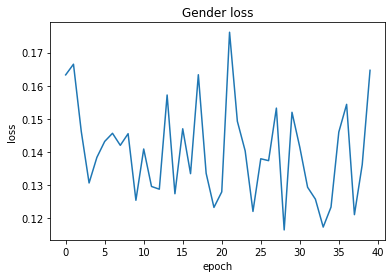

In [21]:
# visualize loss 40 epochs next
plt.plot(his.history['loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [16]:
# save parameters after training 140 epochs
model.save("d:/Học tập 3/Digital_Processing/Project2/utkcropped/output/cnn_logs/model_140_epochs_age_balan.h5", save_format='h5')

In [23]:
# calculate confusion matrix after training 140 epochs
maxt2 = confusion_matrix(data.age,model.predict(train_data_age).argmax(axis=-1))
maxt2

1800/1800 [==============================] - 137s 76ms/step


array([[1959,   16,    7,    7,    1,    7,    0,    0,    3],
       [   3, 1721,   59,   29,   36,  110,   29,    6,    7],
       [   2,  115, 1120,  136,  246,  339,   32,    9,    1],
       [   2,   61,   49, 1227,   66,  513,   64,   13,    5],
       [   0,   77,   84,  130,  346, 1017,  308,   34,    4],
       [   3,   31,   16,  110,   50, 1061,  589,  128,   12],
       [   0,   12,    6,   55,    6,  296, 1219,  381,   25],
       [   0,    1,    2,    7,    2,   69,  157, 1701,   61],
       [   2,    4,    0,    4,    0,   25,   28,  288, 1649]],
      dtype=int64)

Normalized confusion matrix


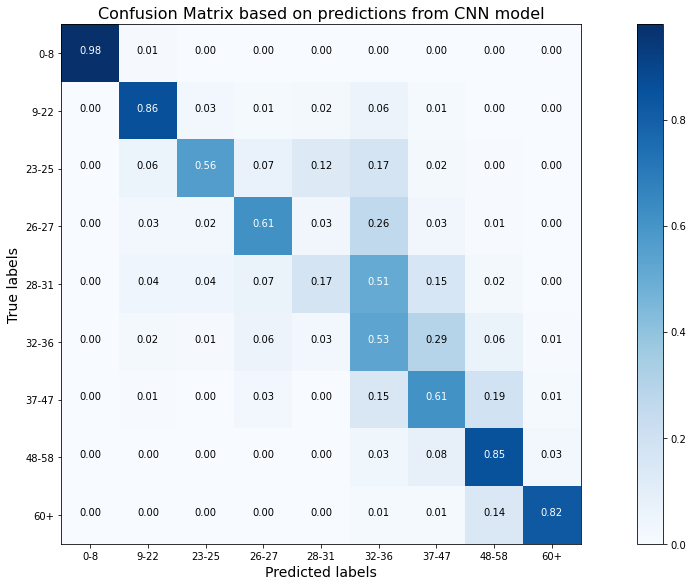

In [26]:
plt.figure(figsize=(16,8))
plot_confusion_matrix(maxt2, age_classes, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="confusion_matrix_after_140_epochs"
                     )

plt.show()